In [ ]:
!pip install -q transformers peft accelerate scikit-learn matplotlib pandas torch seaborn

In [ ]:
import pandas as pd
import numpy as np
import torch
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)

from peft import LoraConfig, get_peft_model, TaskType

In [ ]:
df = pd.read_csv("/content/sample_data/TokopediaLocknLock.csv")
df = df.rename(columns={df.columns[0]: "text"})

print("Jumlah data mentah:", len(df))
df.head()

Jumlah data mentah: 10276


,text
0,bahan botol tipis. setauku pet 1 hanya diguna...
1,"Materialnya bagus, tahan lama, ga gampang rusa..."
2,packing aman ya dan botol ada plastik pembungk...
3,kualitas top. model easy grip sangat OK. packi...
4,Kaget pas datang paketnya dalam dus gede bange...


In [ ]:
#Hapus data kosong & duplikat
df = df.dropna(subset=["text"])
df = df.drop_duplicates()

In [ ]:
def clean_text(text):
    text = str(text).lower()                      # lowercase
    text = re.sub(r"http\S+", "", text)           # hapus URL
    text = re.sub(r"@\w+", "", text)              # hapus mention
    text = re.sub(r"#\w+", "", text)              # hapus hashtag
    text = re.sub(r"[^a-zA-Z\s]", "", text)       # hapus simbol & angka
    text = re.sub(r"\s+", " ", text).strip()      # hapus spasi berlebih
    return text

#Filtering teks terlalu pendek
df = df[df["text"].str.len() >= 5]

print("Jumlah data setelah preprocessing:", len(df))

Jumlah data setelah preprocessing: 10258


In [ ]:
# Simpan versi asli
df["raw_text"] = df["text"]

# Terapkan preprocessing ke kolom baru
df["clean_text"] = df["text"].astype(str).apply(clean_text)

# Membandingkan sebelum dan sesudah preprocessing
sample = df.sample(5, random_state=42)

for i, row in sample.iterrows():
    print("SEBELUM :", row["raw_text"])
    print("SESUDAH :", row["clean_text"])
    print("-" * 80)

SEBELUM : tutupnya kurang pas/tidak presisi
SESUDAH : tutupnya kurang pastidak presisi
--------------------------------------------------------------------------------
SEBELUM : manthap, sesuai ekspektasi
SESUDAH : manthap sesuai ekspektasi
--------------------------------------------------------------------------------
SEBELUM : produk bagusMaterial Produk  Bagus. Kualitas Produk Bagus. Warna Produk Sesuai. Ukuran Produk Sesuai.
SESUDAH : produk bagusmaterial produk bagus kualitas produk bagus warna produk sesuai ukuran produk sesuai
--------------------------------------------------------------------------------
SEBELUM : Produk ori, material OK, tahan panasnya manteb. Kata Bapak saya nyeduh kopi abis Shubuhan klo ditutup gelasnya tahan ampe Maghrib. 🤣👍🏻
SESUDAH : produk ori material ok tahan panasnya manteb kata bapak saya nyeduh kopi abis shubuhan klo ditutup gelasnya tahan ampe maghrib
--------------------------------------------------------------------------------
SEBELUM : bagus

In [ ]:
#Pemberian Label
def label_sentiment(text):
    positive_words = ["bagus", "mantap","murah","baik","awet","bonus","terima kasih","amanah","promo","puas","gratis","cocok", "asli","keren","sesuai","cepat","senang","tebal","berguna","diskon","kualitas","rapi","kokoh", "manfaat","tahan","suka","langganan"]
    negative_words = ["jelek","tipis","bau","sobek","lecet","lambat","parah","debu","kotor","plastik", "rusak", "kecewa","cacat", "salah","buruk", "retak", "penyok","bocor","sampah", "sobek","pecah","tidak sesuai","hancur","mahal","tapi"]

    pos = sum(w in text for w in positive_words)
    neg = sum(w in text for w in negative_words)

    if pos > neg:
        return "positive"
    elif neg > pos:
        return "negative"
    else:
        return "neutral"

df["label"] = df["text"].apply(label_sentiment)

print("\nDistribusi label:")
print(df["label"].value_counts())
df["label"] = df["text"].apply(label_sentiment)
print("\nDistribusi label setelah optimasi:")
print(df["label"].value_counts(normalize=True) * 100)


Distribusi label:
label
positive    7054
neutral     2497
negative     707
Name: count, dtype: int64

Distribusi label setelah optimasi:
label
positive    68.765841
neutral     24.341977
negative     6.892182
Name: proportion, dtype: float64


In [ ]:
from transformers import pipeline
import pandas as pd

# 1. Inisialisasi pipeline Zero-Shot Classification
# Kita gunakan model yang mendukung multibahasa (termasuk Indonesia)
classifier = pipeline("zero-shot-classification",
                      model="facebook/bart-large-mnli") # Atau model lain yang suport Indonesia

def label_zero_shot(text):
    candidate_labels = ["positif", "negatif", "netral"]

    # Gunakan hypothesis_template dalam Bahasa Indonesia agar model lebih paham konteks
    hypothesis_template = "Teks ini memiliki sentimen {}."

    result = classifier(text, candidate_labels, hypothesis_template=hypothesis_template)

    # Mengambil label dengan skor kepercayaan (score) tertinggi
    return result['labels'][0]

# 2. Terapkan pada DataFrame
# Catatan: Zero-shot agak lambat, gunakan subset data dulu untuk testing
df["label_zero_shot"] = df["text"].apply(label_zero_shot)

print("\nDistribusi label Zero-Shot:")
print(df["label_zero_shot"].value_counts(normalize=True) * 100)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Distribusi label Zero-Shot:
label_zero_shot
negatif    51.247807
positif    31.750829
netral     17.001365
Name: proportion, dtype: float64


In [ ]:
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])

In [ ]:
#Pembagian data untuk training, validation dan testing menjadi 70:15:15
texts = df["clean_text"]
labels = df["label"]

X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels,
    test_size=0.30,
    random_state=42,
    stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.50,
    random_state=42,
    stratify=y_temp
)

train_texts = X_train
val_texts = X_val
test_texts = X_test

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

label_map = {idx: label for idx, label in enumerate(label_encoder.classes_)}

# Assign encoded labels back to y_train, y_val, y_test for subsequent steps
y_train = y_train_encoded
y_val = y_val_encoded
y_test = y_test_encoded

print("\nJumlah data:")
print("Train:", len(train_texts))
print("Validation:", len(val_texts))
print("Test:", len(test_texts))

print("\nDistribusi label (encoded):")
print(pd.Series(y_train_encoded).value_counts())


Jumlah data:
Train: 7180
Validation: 1539
Test: 1539

Distribusi label (encoded):
2    4937
1    1748
0     495
Name: count, dtype: int64


In [ ]:
#Tokenisasi indoBert
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)

train_enc = tokenizer(list(train_texts), truncation=True)
val_enc   = tokenizer(list(val_texts), truncation=True)
test_enc  = tokenizer(list(test_texts), truncation=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
class ReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.tolist()

    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k, v in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewDataset(train_enc, y_train)
val_dataset   = ReviewDataset(val_enc, y_val)
test_dataset  = ReviewDataset(test_enc, y_test)

In [ ]:
#HHitung class weight
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)

Class weights: tensor([4.8350, 1.3692, 0.4848])


In [ ]:
#model + LoRA PEFT
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(le.classes_)
)

lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 297,219 || all params: 124,740,870 || trainable%: 0.2383


In [ ]:
# CUSTOM TRAINER (WEIGHTED LOSS)
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
        loss = loss_fn(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [ ]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=10,
    learning_rate=1e-5,
    logging_steps=50,
    save_strategy="no",
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer)

In [ ]:
# Fungsi evaluasi
def compute_metrics(eval_pred):
    logits, labels = eval_pred.predictions, eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1}

In [ ]:
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

Step,Training Loss
50,0.559500
100,0.495000
150,0.527400
200,0.512200
250,0.519600
300,0.514600
350,0.508000
400,0.491400
450,0.536000
500,0.458200


TrainOutput(global_step=2250, training_loss=0.48896651458740237, metrics={'train_runtime': 308.5711, 'train_samples_per_second': 232.685, 'train_steps_per_second': 7.292, 'total_flos': 1298669907893040.0, 'train_loss': 0.48896651458740237, 'epoch': 10.0})

In [ ]:
eval_results = trainer.evaluate()
print("\nEvaluation Results:", eval_results)


Evaluation Results: {'eval_loss': 0.45407238602638245, 'eval_accuracy': 0.8193632228719948, 'eval_f1': 0.8246052570553688, 'eval_runtime': 3.3499, 'eval_samples_per_second': 459.411, 'eval_steps_per_second': 14.627, 'epoch': 10.0}


In [ ]:
test_dataset = ReviewDataset(
    encodings=test_enc,
    labels=y_test
)

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

# y_test is already a numpy array, no need for conversion or reset_index
y_true = y_test

print(len(y_true), len(y_pred))  # harus sama

1539 1539


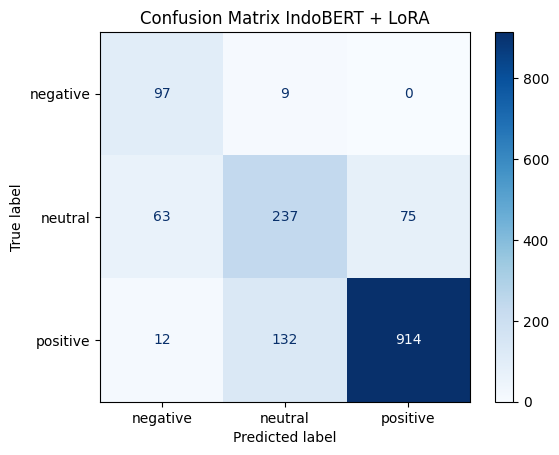

In [ ]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = y_test

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix IndoBERT + LoRA")
plt.show()